# Stock prediction

Using 3 different types of regression models to predict the price of a stock for a future date:
- Linear regression
- Ridge regression
- Lasso regression

### Imports

In [1]:
# Machine learning
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Data manipulation and analysis
import pandas as pd
from pandas_datareader import data as pdr
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Scientific computing
import numpy as np

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
#import seaborn as sns
#sns.set()

# Market data
import yfinance as yf
yf.pdr_override()

# Date
from datetime import date, datetime, timedelta

### Parameters

In [2]:
# Using company <TICKER> stock market data for the past <PERIOD>, and forecasting the last <FORECAST_TIME_WINDOW> days
TICKER = 'AAPL'
PERIOD = '1y'
FORECAST_TIME_WINDOW = 7

### Data preparation

In [3]:
data = pdr.get_data_yahoo(TICKER, period=PERIOD).reset_index()
data['OrdinalDate'] = data['Date'].apply(lambda x: x.toordinal())
data.head()

[*********************100%***********************]  1 of 1 downloaded


,Date,Open,High,Low,Close,Adj Close,Volume,OrdinalDate
0,2018-09-10,220.95,221.85,216.47,218.33,214.99,39516500,736947
1,2018-09-11,218.01,224.30,216.56,223.85,220.43,35749000,736948
2,2018-09-12,224.94,225.00,219.84,221.07,217.69,49278700,736949
3,2018-09-13,223.52,228.35,222.57,226.41,222.95,41706400,736950
4,2018-09-14,225.75,226.84,222.52,223.84,220.42,31999300,736951


### Data visualization

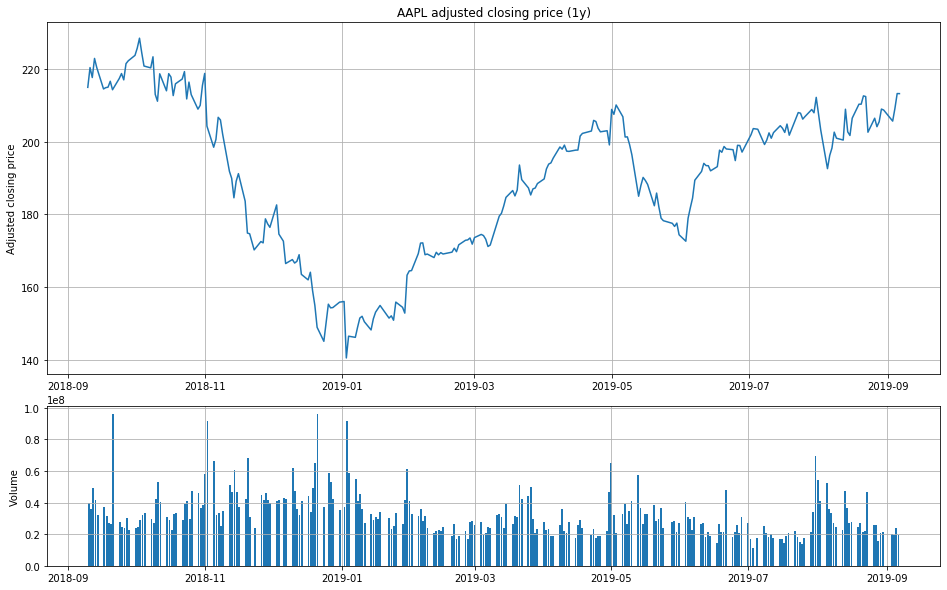

In [4]:
plt.figure(figsize=(16, 10))

price_ax = plt.subplot2grid((3, 3), (0, 0), rowspan=2, colspan=4)
price_ax.set_title(TICKER + ' adjusted closing price (' + PERIOD + ')')
price_ax.plot(data.Date, data['Adj Close'])
price_ax.set_ylabel('Adjusted closing price')
price_ax.grid(True)

volume_ax = plt.subplot2grid((3, 3), (2, 0), rowspan=1, colspan=4)
volume_ax.bar(data.Date, data.Volume)
volume_ax.set_ylabel('Volume')
volume_ax.grid(True)

plt.show()

### Data inputs and outputs

In [5]:
# We can only user the date to forecast the stock market price,
# as it's the only data we have to predict the future.
# Using more features is useful to predict data up until the present time.
#features = ['OrdinalDate', 'Open', 'Low', 'High', 'Close', 'Volume']
features = ['OrdinalDate']
X = data[features]

labels = ['Adj Close']
y = data[labels]

### Data split

In [6]:
# Because this is a time series, continous temporal values are important,
# therefore we cannot random shuffle a training and a testing set.
train_size = int(len(data) * 0.80)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print('Samples:', (len(X)))
print('Training samples:', (len(X_train)))
print('Testing samples:', (len(X_test)))

Samples: 250
Training samples: 200
Testing samples: 50


### Data training

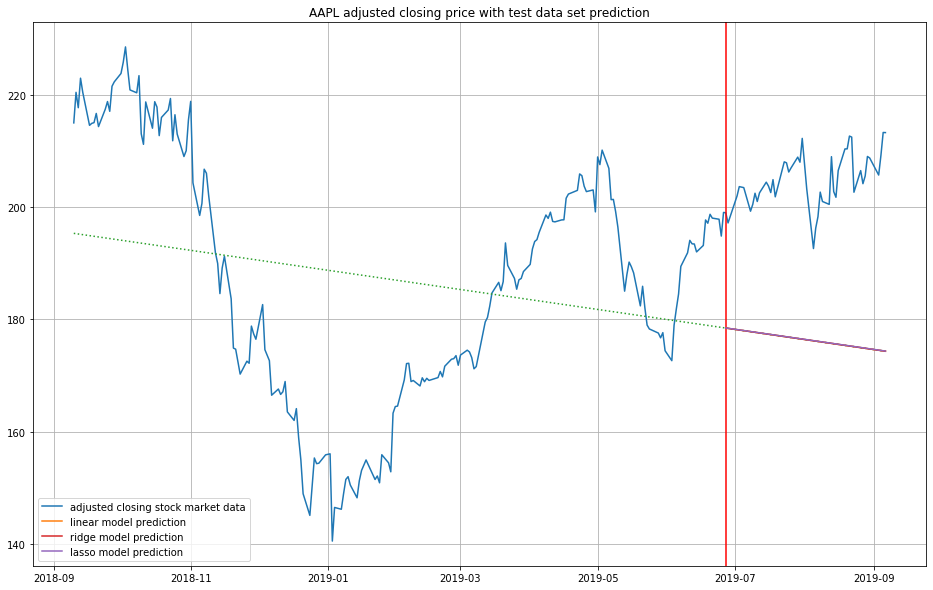

In [7]:
# We are using linear, ridge and lasso regression
linear_regression = linear_model.LinearRegression()
ridge_regression = linear_model.Ridge()
lasso_regression = linear_model.Lasso()

# Train the models using the training sets
linear_regression.fit(X_train, y_train)
ridge_regression.fit(X_train, y_train)
lasso_regression.fit(X_train, y_train)

# Visualize predictions
plt.figure(figsize=(16, 10))
plt.title(TICKER + ' adjusted closing price with test data set prediction')
plt.plot(data.Date, data['Adj Close'], label='adjusted closing stock market data')
plt.axvline(data.Date[train_size:].head(1), color='red')
plt.plot(data.Date[train_size:], linear_regression.predict(X_test), label='linear model prediction')
plt.plot(data.Date, linear_regression.predict(X), linestyle=':')
plt.plot(data.Date[train_size:], ridge_regression.predict(X_test), label='ridge model prediction')
plt.plot(data.Date[train_size:], lasso_regression.predict(X_test), label='lasso model prediction')
plt.legend()
plt.grid(True)
plt.show()

### Data forecasting

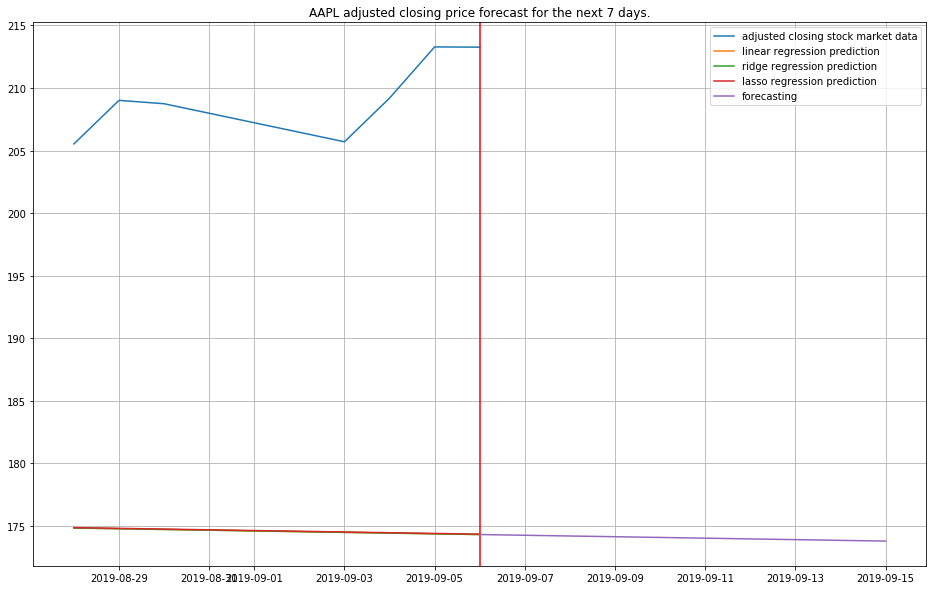

In [8]:
forecasting_data = pd.DataFrame()
last_stock_market_day = data.Date.iat[-1]
forecasting_data['Date'] = pd.date_range(start=last_stock_market_day, end=datetime.now()+timedelta(days=FORECAST_TIME_WINDOW))
forecasting_data['OrdinalDate'] = forecasting_data['Date'].apply(lambda x: x.toordinal())

X_forecasting = forecasting_data[['OrdinalDate']]

plt.figure(figsize=(16, 10))
plt.title(TICKER + ' adjusted closing price forecast for the next ' + str(FORECAST_TIME_WINDOW) + ' days.')
plt.plot(data.Date[-FORECAST_TIME_WINDOW:], data['Adj Close'][-FORECAST_TIME_WINDOW:], label='adjusted closing stock market data')
plt.plot(data.Date[-FORECAST_TIME_WINDOW:], linear_regression.predict(X_test[-FORECAST_TIME_WINDOW:]), label='linear regression prediction')
plt.plot(data.Date[-FORECAST_TIME_WINDOW:], ridge_regression.predict(X_test[-FORECAST_TIME_WINDOW:]), label='ridge regression prediction')
plt.plot(data.Date[-FORECAST_TIME_WINDOW:], lasso_regression.predict(X_test[-FORECAST_TIME_WINDOW:]), label='lasso regression prediction')
plt.axvline(last_stock_market_day, color='red')
plt.plot(forecasting_data.Date, linear_regression.predict(X_forecasting), label='forecasting')
plt.legend()
plt.grid(True)
plt.show()

### Data score

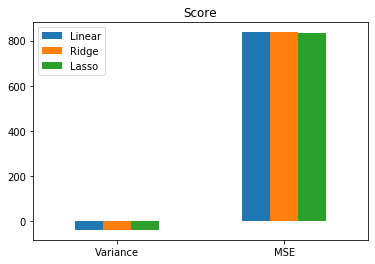

Linear regression
- Variance score: -38.715896202977454
- Mean squared error: 837.0503553722878
Ridge regression
- Variance score: -38.71587608235419
- Mean squared error: 837.0499313109808
Lasso regression
- Variance score: -38.64673366432616
- Mean squared error: 835.5926889693784


In [9]:
# Compute scores on testing sets
y_linear_regression_prediction = linear_regression.predict(X_test)
y_ridge_regression_prediction = ridge_regression.predict(X_test)
y_lasso_regression_prediction = lasso_regression.predict(X_test)

score_data = pd.DataFrame(columns=['Linear', 'Ridge', 'Lasso'], index=['Variance', 'MSE'])
score_data.Linear = [linear_regression.score(X_test, y_test), mean_squared_error(y_test, y_linear_regression_prediction)]
score_data.Ridge = [ridge_regression.score(X_test, y_test), mean_squared_error(y_test, y_ridge_regression_prediction)]
score_data.Lasso = [lasso_regression.score(X_test, y_test), mean_squared_error(y_test, y_lasso_regression_prediction)]
score_data.plot(kind='bar', title='Score', rot=0)
plt.show()

print('Linear regression')
print('- Variance score:', linear_regression.score(X_test, y_test))
print('- Mean squared error:', mean_squared_error(y_test, y_linear_regression_prediction))

print('Ridge regression')
print('- Variance score:', ridge_regression.score(X_test, y_test))
print('- Mean squared error:', mean_squared_error(y_test, y_ridge_regression_prediction))

print('Lasso regression')
print('- Variance score:', lasso_regression.score(X_test, y_test))
print('- Mean squared error:', mean_squared_error(y_test, y_lasso_regression_prediction))

### Results

We can observe that every regression used for prediction is similarly bad and unusable, as only using the date as a feature results in a linear function which is not well suited for this type of analysis.

For future work, we could use more advanced techniques than regression with linear models.